Import Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FixedLocator
import os

Build Vocabulary

In [ ]:
# Function to build the vocabulary
def build_vocab(file_path):
    """
    Args:
        file_path (str): Path to the dataset file.

    Returns:
        tuple: input_vocab, output_vocab, input_vocab_inv, output_vocab_inv
    """
    input_vocab = defaultdict(lambda: len(input_vocab))
    output_vocab = defaultdict(lambda: len(output_vocab))

    input_vocab['<PAD>'] = 0
    input_vocab['<UNK>'] = 1
    output_vocab['<PAD>'] = 0
    output_vocab['<UNK>'] = 1
    output_vocab['<SOS>'] = 2
    output_vocab['<EOS>'] = 3

    with open(file_path, 'r') as file:
        for line in file:
            input_sent, output_sent = line.strip().split(',')
            input_sent = input_sent.strip().strip("'")
            output_sent = output_sent.strip().strip("'")

            for char in input_sent:
                input_vocab[char]
            for char in output_sent:
                output_vocab[char]

    input_vocab = dict(input_vocab)
    output_vocab = dict(output_vocab)
    input_vocab_inv = {v: k for k, v in input_vocab.items()}
    output_vocab_inv = {v: k for k, v in output_vocab.items()}

    return input_vocab, output_vocab, input_vocab_inv, output_vocab_inv

# Build vocabularies
input_vocab, output_vocab, input_vocab_inv, output_vocab_inv = build_vocab('/content/train.txt')

Create DataLoader

In [ ]:
class DateTranslationDataset(Dataset):
    def __init__(self, file_path, input_vocab, output_vocab, max_input_len, max_output_len=10):
        """
        Args:
            file_path (str): Path to the data file.
            input_vocab (dict): Input vocabulary.
            output_vocab (dict): Output vocabulary.
            max_input_len (int): Maximum length of input sequence.
            max_output_len (int): Maximum length of output sequence.
        """
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len
        self.data = self.load_data(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0]), torch.tensor(self.data[idx][1])

    def load_data(self, file_path):
        data = []
        with open(file_path, 'r') as file:
            for line in file:
                input_sent, output_sent = line.strip().split(',')
                input_sent = input_sent.strip().strip("'")
                output_sent = output_sent.strip().strip("'")

                input_ids = [self.input_vocab.get(char, self.input_vocab['<UNK>']) for char in input_sent][:self.max_input_len]
                output_ids = [self.output_vocab.get(char, self.output_vocab['<UNK>']) for char in output_sent][:self.max_output_len]

                # Padding on left side
                input_ids = [self.input_vocab['<PAD>']] * (self.max_input_len - len(input_ids)) + input_ids
                output_ids = [self.output_vocab['<PAD>']] * (self.max_output_len - len(output_ids)) + output_ids

                output_ids = [self.output_vocab['<SOS>']] + output_ids + [self.output_vocab['<EOS>']]

                data.append((input_ids, output_ids))
        return data

def get_dataloader(file_path, input_vocab, output_vocab, max_input_len, max_output_len, batch_size):
    dataset = DateTranslationDataset(file_path, input_vocab, output_vocab, max_input_len, max_output_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Set parameters and create dataloaders
max_input_len = 20
max_output_len = 10
batch_size = 32

trainloader = get_dataloader('/content/train.txt', input_vocab, output_vocab, max_input_len, max_output_len, batch_size)
validloader = get_dataloader('/content/validation.txt', input_vocab, output_vocab, max_input_len, max_output_len, batch_size)

Define the Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, emb_dim, enc_hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.W_a = nn.Linear(dec_hid_dim, dec_hid_dim)
        self.U_a = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        projected_hidden = self.W_a(hidden.unsqueeze(1))
        energy = torch.tanh(projected_hidden + self.U_a(encoder_outputs))
        attention = self.v(energy).squeeze(2)
        attention_weights = torch.softmax(attention, dim=1)
        return attention_weights

class Decoder(nn.Module):
    def __init__(self, output_vocab_size, emb_dim, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.output_vocab_size = output_vocab_size
        self.attention = BahdanauAttention(enc_hid_dim, dec_hid_dim)
        self.embedding = nn.Embedding(output_vocab_size, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, batch_first=True)
        self.fc = nn.Linear(dec_hid_dim, output_vocab_size)

    def forward(self, x, hidden, encoder_outputs):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        attention_weights = self.attention(hidden, encoder_outputs)
        attention_weights = attention_weights.unsqueeze(1)
        context_vector = torch.bmm(attention_weights, encoder_outputs)
        rnn_input = torch.cat((embedded, context_vector), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden.squeeze(0), attention_weights.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input, target, teacher_forcing_ratio=0.5):
        batch_size = input.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_vocab_size

        outputs = torch.zeros(batch_size, target_len - 1, target_vocab_size).to(self.device)
        attention_scores = torch.zeros(batch_size, target_len - 1, input.shape[1]).to(self.device)

        encoder_outputs, hidden = self.encoder(input)
        x = target[:, 0]  # <SOS> token

        for t in range(1, target_len):
            output, hidden, attention_weights = self.decoder(x, hidden, encoder_outputs)
            attention_scores[:, t - 1] = attention_weights
            outputs[:, t - 1] = output
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            top1 = output.argmax(1)
            x = target[:, t] if teacher_force else top1

        return outputs, attention_scores

# Set model parameters
input_vocab_size = len(input_vocab)
output_vocab_size = len(output_vocab)
embedding_size = 128
enc_hidden_size = 128
dec_hidden_size = 2 * 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
encoder = Encoder(input_vocab_size, embedding_size, enc_hidden_size)
decoder = Decoder(output_vocab_size, embedding_size, enc_hidden_size, dec_hidden_size)
model = Seq2Seq(encoder, decoder, device).to(device)

Training Functions

In [ ]:
def train_model(model, trainloader, validloader, epochs, optimizer, criterion, device):
    model.train()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        print('*' * 20 + f'Epoch {epoch + 1}' + '*' * 20)
        for src, tgt in trainloader:
            src = src.to(device)
            tgt = tgt.to(device)
            optimizer.zero_grad()
            output, _ = model(src, tgt)
            tgt = tgt[:, 1:]
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            tgt = tgt.reshape(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch: {epoch + 1:02}')
        print(f'Train Loss: {epoch_loss / len(trainloader):.3f}')
        print(f'Validation Loss: {evaluate_model(model, validloader, criterion, device):.3f}')
    # Save the model
    if not os.path.exists('Models'):
        os.makedirs('Models')
    torch.save(model.state_dict(), 'Models/model.pth')

def evaluate_model(model, validloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, tgt in validloader:
            src = src.to(device)
            tgt = tgt.to(device)
            output, _ = model(src, tgt, 0)  # Turn off teacher forcing
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            tgt = tgt[:, 1:]
            tgt = tgt.reshape(-1)
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    return epoch_loss / len(validloader)

Train the Model

In [ ]:
# Training parameters
learning_rate = 0.001
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=output_vocab['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, trainloader, validloader, num_epochs, optimizer, criterion, device)

********************Epoch 1********************
Epoch: 01
Train Loss: 0.175
Validation Loss: 0.064
********************Epoch 2********************
Epoch: 02
Train Loss: 0.066
Validation Loss: 0.067
********************Epoch 3********************
Epoch: 03
Train Loss: 0.064
Validation Loss: 0.062
********************Epoch 4********************
Epoch: 04
Train Loss: 0.064
Validation Loss: 0.063
********************Epoch 5********************
Epoch: 05
Train Loss: 0.063
Validation Loss: 0.063
********************Epoch 6********************
Epoch: 06
Train Loss: 0.065
Validation Loss: 0.063
********************Epoch 7********************
Epoch: 07
Train Loss: 0.063
Validation Loss: 0.065
********************Epoch 8********************
Epoch: 08
Train Loss: 0.063
Validation Loss: 0.062
********************Epoch 9********************
Epoch: 09
Train Loss: 0.063
Validation Loss: 0.062
********************Epoch 10********************
Epoch: 10
Train Loss: 0.062
Validation Loss: 0.065


Visualize Attention

Source: 29 February 2020
Predicted: 2020-02-29


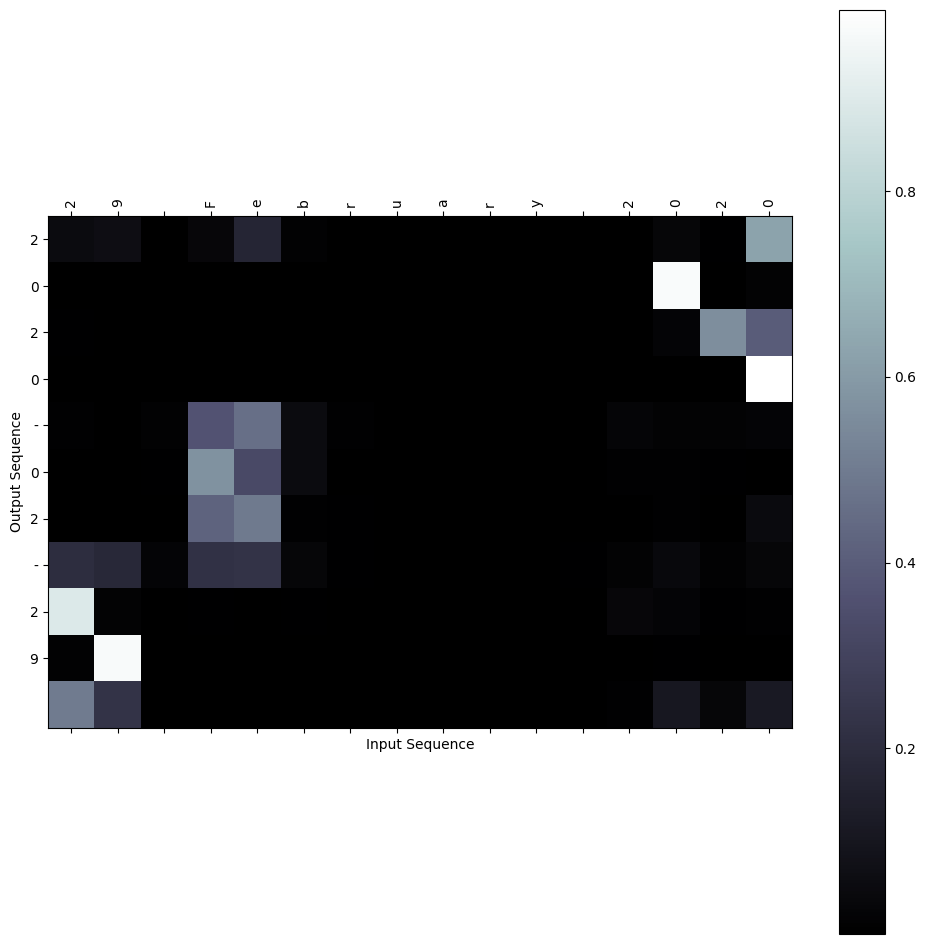

<Figure size 640x480 with 0 Axes>

In [ ]:
def predict(model, src, src_vocab, tgt_vocab, tgt_inv_vocab, max_len, device):
    model.eval()
    src_seq = [src_vocab.get(char, src_vocab['<UNK>']) for char in src]
    src_tensor = torch.tensor(src_seq).unsqueeze(0).to(device)
    tgt_seq = [tgt_vocab['<SOS>']] + [tgt_vocab['<PAD>']] * max_len + [tgt_vocab['<EOS>']]
    tgt_tensor = torch.tensor(tgt_seq).unsqueeze(0).to(device)
    outputs, attention_scores = model(src_tensor, tgt_tensor, 0)
    outputs = outputs.squeeze(0)
    decoder_outputs = []
    for output in outputs:
        output_token = output.argmax(0).item()
        if output_token == tgt_vocab['<EOS>']:
            break
        decoder_outputs.append(tgt_inv_vocab[output_token])
    return decoder_outputs, attention_scores

def attention_visualization(model, src, input_vocab, output_vocab, output_vocab_inv, max_output_len, device):
    outputs, attention_scores = predict(model, src, input_vocab, output_vocab, output_vocab_inv, max_output_len, device)
    src_tokens = [char for char in src]
    tgt_tokens = outputs
    attention_scores = attention_scores.squeeze(0).cpu().detach().numpy()
    print('Source:', src)
    print('Predicted:', "".join(outputs))
    fig, ax = plt.subplots(figsize=(12, 12))
    cax = ax.matshow(attention_scores, cmap='bone')
    ax.set_xticks(np.arange(len(src_tokens)))
    ax.set_yticks(np.arange(len(tgt_tokens)))
    ax.set_xticklabels(src_tokens, rotation=90)
    ax.set_yticklabels(tgt_tokens)
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    fig.colorbar(cax)
    plt.show()
    # Save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/attention.png')

# Example usage
attention_visualization(model, '29 February 2020', input_vocab, output_vocab, output_vocab_inv, max_output_len, device)